# U-Net Practice

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# GPU version
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12138370603982234924,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22711107584
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 902577413114098905
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6"]

Reference: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer

# Import data

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="True"

# Load CIFAR-10 dataset
num_classes = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Training data sets: {x_train.shape}")
print(f"Training label sets: {y_train.shape}")
print(f"Test data sets: {x_test.shape}")
print(f"Test label sets: {y_test.shape}")


Training data sets: (50000, 32, 32, 3)
Training label sets: (50000, 1)
Test data sets: (10000, 32, 32, 3)
Test label sets: (10000, 1)


# Preprocessing

In [4]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

(-0.5, 31.5, 31.5, -0.5)

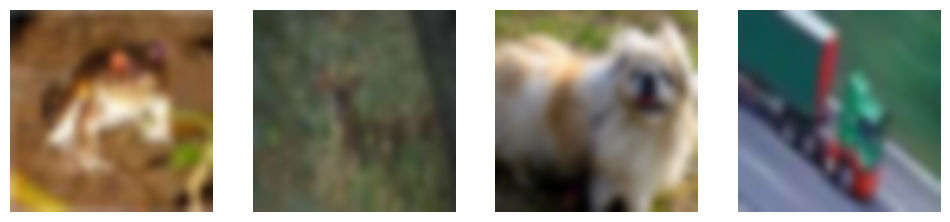

In [5]:
plt.figure(figsize= (12,4))

plt.subplot(1,4,1)
plt.imshow(x_train[0],interpolation="bicubic")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(x_train[10],interpolation="bicubic")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(x_train[40],interpolation="bicubic")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(x_train[50],interpolation="bicubic")
plt.axis("off")

# Defining the U-net architecture

In [6]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
# Define U-Net model
def unet_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Contracting path/downsampling
    c1 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = BatchNormalization()(p1)
    c2 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = BatchNormalization()(p2)
    c3 = Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottom/latent path
    c4 = BatchNormalization()(p3)
    c4 = Conv2D(256, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    
    # Expansive path/upsampling
    c5 = BatchNormalization()(c4)
    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    c6 = BatchNormalization()(c5)
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    c7 = BatchNormalization()(c6)
    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    # Output layer
    c8 = Conv2D(10, (1, 1), activation='relu', name="Outputs")(c7)

    nodes = Flatten()(c8)
    outputs = Dense(num_classes, activation="softmax")(nodes)
    # outputs = Dense(num_classes, activation="relu")(nodes)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Define input shape
input_shape = x_train.shape[1:]

# Create the U-Net model
model = unet_model(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   25632       dropout[0][0]                    
______________________________________________________________________________________________

# Compiling with checkpoints & Early stop

In [7]:
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [8]:
# * Checkpoint
checkpoint_path = 'unet_cifar10_checkpoint.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [9]:
# * Early Stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)

In [10]:
# * Compile
# model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy','Precision'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

metrics https://www.tensorflow.org/api_docs/python/tf/keras/metrics

# Model Training

In [11]:
# Mini batch size
batch_size = 64
# No. of batch = iterations
iterations_number = x_train.shape[0]/batch_size
# No. of Epochs
epochs = 20

print(f"Batch size: {batch_size}")
print(f"No. of training datasets: {x_train.shape[0]}")
print(f"No. of iterations: {iterations_number}")
print(f"No. of Epochs: {epochs}")

Batch size: 64
No. of training datasets: 50000
No. of iterations: 781.25
No. of Epochs: 20


In [12]:
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[checkpoint,early_stop])

Epoch 1/20
782/782 [==============================] - 34s 34ms/step - loss: 1.4817 - accuracy: 0.4583 - precision: 0.6806 - val_loss: 1.5141 - val_accuracy: 0.5065 - val_precision: 0.5973

Epoch 00001: val_loss improved from inf to 1.51412, saving model to unet_cifar10_checkpoint.h5
Epoch 2/20
782/782 [==============================] - 26s 34ms/step - loss: 1.0413 - accuracy: 0.6273 - precision: 0.7603 - val_loss: 1.0619 - val_accuracy: 0.6289 - val_precision: 0.7359

Epoch 00002: val_loss improved from 1.51412 to 1.06187, saving model to unet_cifar10_checkpoint.h5
Epoch 3/20
782/782 [==============================] - 25s 32ms/step - loss: 0.8582 - accuracy: 0.6972 - precision: 0.7965 - val_loss: 0.9024 - val_accuracy: 0.6775 - val_precision: 0.7946

Epoch 00003: val_loss improved from 1.06187 to 0.90242, saving model to unet_cifar10_checkpoint.h5
Epoch 4/20
782/782 [==============================] - 26s 33ms/step - loss: 0.7452 - accuracy: 0.7375 - precision: 0.8211 - val_loss: 0.9947

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])


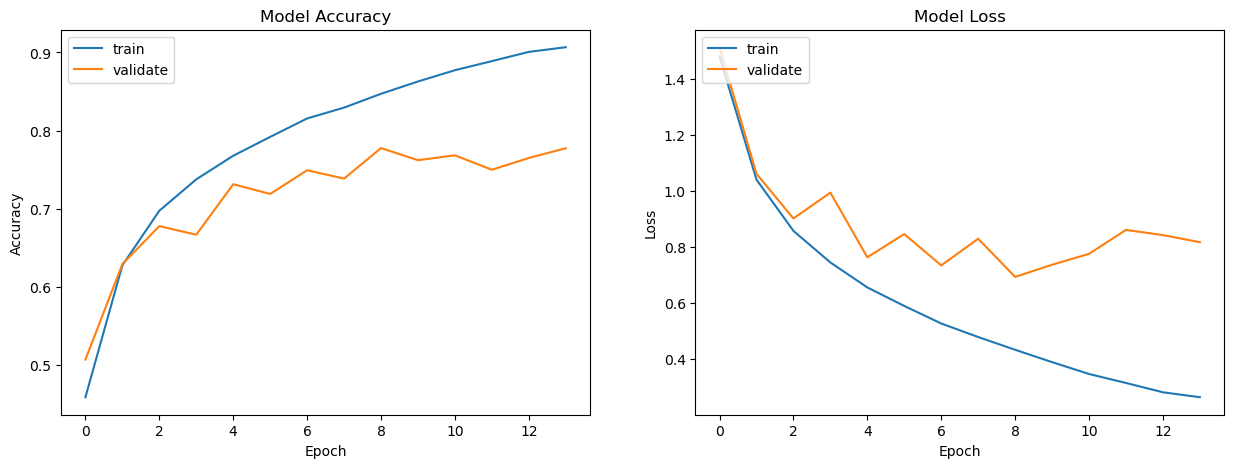

In [13]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [14]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.8176 - accuracy: 0.7773 - precision: 0.8037
Test loss: 0.8176174163818359
Test accuracy: 0.7773000001907349


# Score trained model and prediction

In [15]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

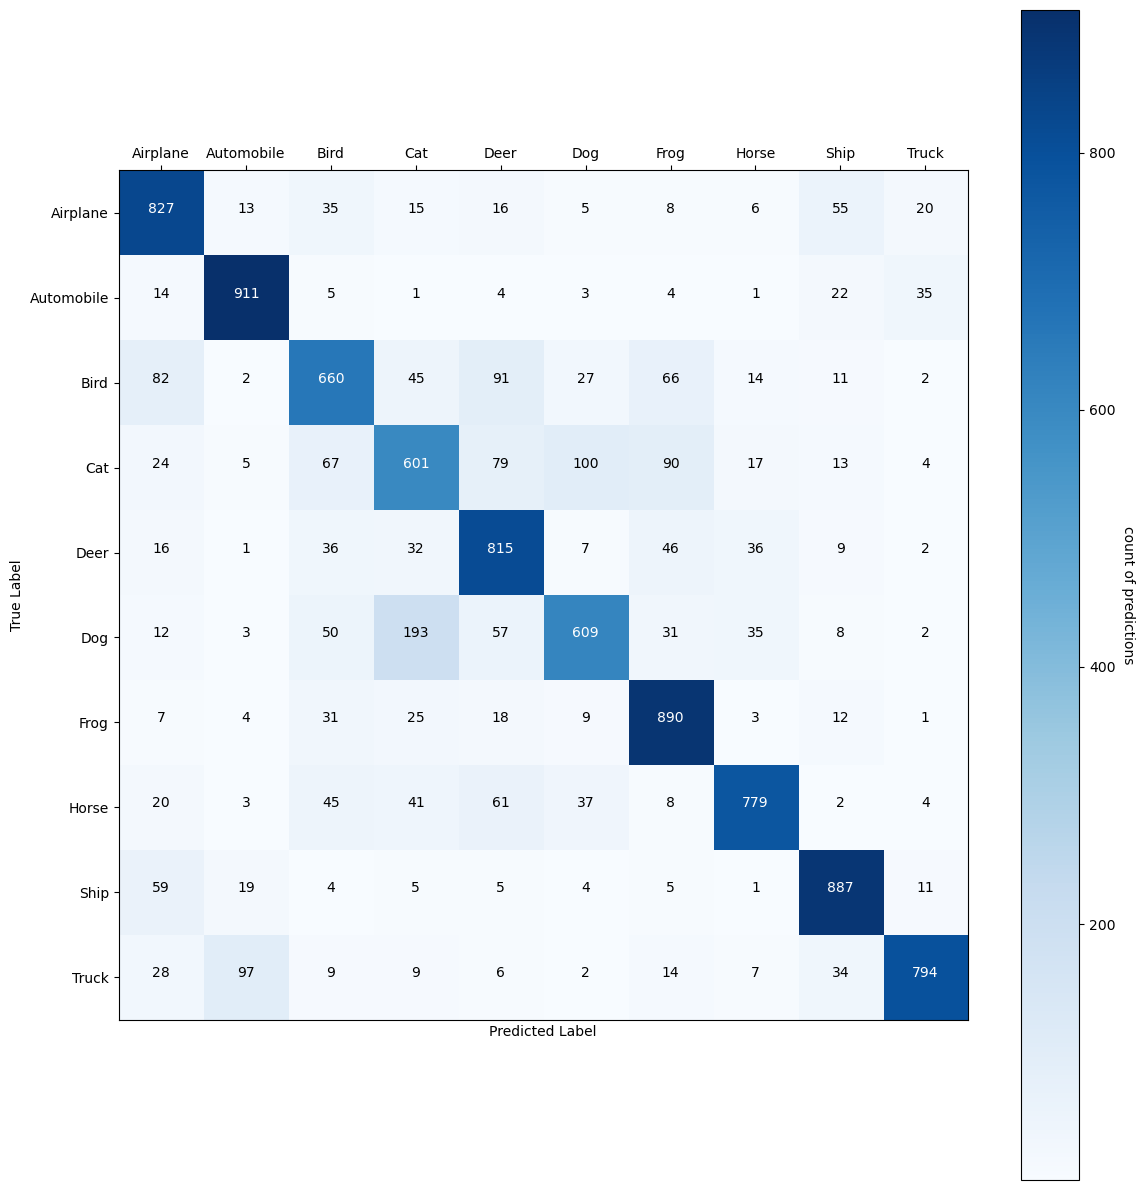

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

# Classification report

In [17]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1000
           1       0.86      0.91      0.89      1000
           2       0.70      0.66      0.68      1000
           3       0.62      0.60      0.61      1000
           4       0.71      0.81      0.76      1000
           5       0.76      0.61      0.68      1000
           6       0.77      0.89      0.82      1000
           7       0.87      0.78      0.82      1000
           8       0.84      0.89      0.86      1000
           9       0.91      0.79      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



## Check the predictions

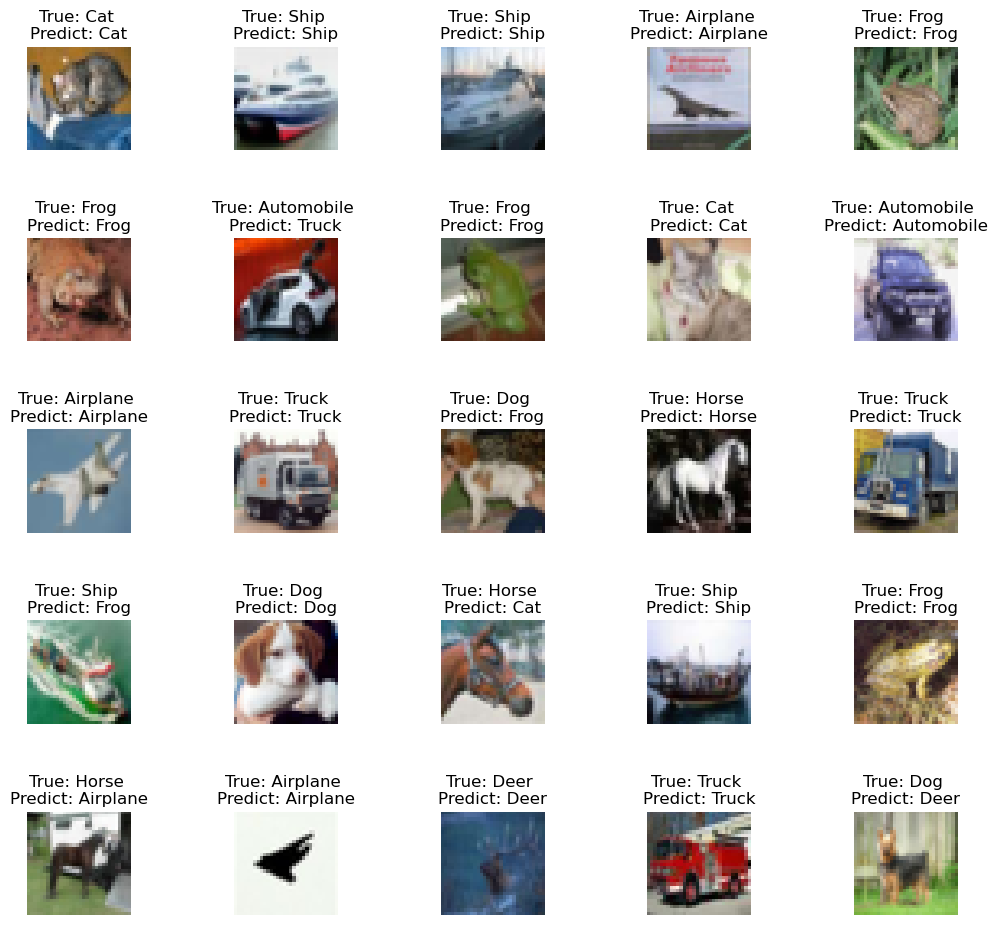

In [18]:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

## Check the wrong predictions

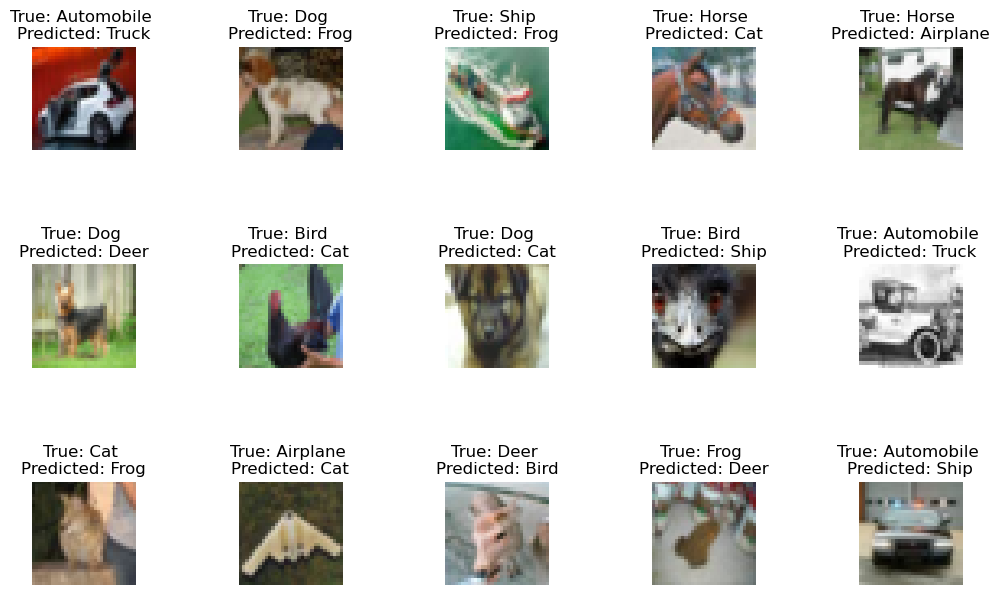

In [19]:
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                    labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)